# This notebook aims to find out whether DataAugmentation can help boosting the final CV / test results of an EffNetB0 model

In [1]:
import pathlib
import os
import torchvision
from torch.mps import is_available
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torchinfo
from time import time
import numpy as np

try:
    from scripts import dataset_setup
    from scripts import utilities
    from scripts import model_setup
except ImportError:
    print('The helper scripts are not present in the working folder... downloading them from github repository:\n\t'
          'https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke/tree/main/05_PyTorch_Food101/scripts')
    !git clone https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke
    !mv ./PyTorch_Course_by_Daniel_Bourke/05_PyTorch_Food101/scripts .
    !rm -rf ./PyTorch_Course_by_Daniel_Bourke 
    from scripts import dataset_setup
    from scripts import utilities
    from scripts import model_setup
    print('Dependencies properly imported...')


The helper scripts are not present in the working folder... downloading them from github repository:
	https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke/tree/main/05_PyTorch_Food101/scripts
Cloning into 'PyTorch_Course_by_Daniel_Bourke'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 138 (delta 48), reused 123 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (138/138), 10.76 MiB | 25.81 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Dependencies properly imported...


## 1. Importing the model chosen for the testing (aiming to deploy an hypothetical app which goes on mobile devices)

In [3]:
model = model_setup.EffNetB2(name='EfficientNetB2')

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /Users/thomaspierantozzi/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 41.7MB/s]


### Testing the model functionality via torchinfo and getting some info

In [4]:
torchinfo.summary(model,
                  input_size=(1, 3, 256, 256),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable']
                  )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
EffNetB2                                 [1, 3, 256, 256]          [1, 1000]                 --                        True
├─ModuleList: 1-1                        --                        --                        --                        True
│    └─Sequential: 2-1                   [1, 3, 256, 256]          [1, 1408, 8, 8]           7,700,994                 True
│    └─Conv2dNormActivation: 2-2         [1, 3, 256, 256]          [1, 32, 128, 128]         928                       True
│    └─Conv2d: 2-3                       [1, 3, 256, 256]          [1, 32, 128, 128]         864                       True
│    └─BatchNorm2d: 2-4                  [1, 32, 128, 128]         [1, 32, 128, 128]         64                        True
│    └─SiLU: 2-5                         [1, 32, 128, 128]         [1, 32, 128, 128]         --                        --
│    

In [5]:
device = 'mps' if is_available() else 'cpu'
model.to(device)


EffNetB2(
  (architecture): ModuleList(
    (0): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          

### Freezing the layers belonging to the 'Feature Extractor'

In [6]:
for param in model.features.parameters():
    param.requires_grad = False

In [7]:
torchinfo.summary(model,
                  input_size=(1, 3, 224, 224),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable']
                  )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
EffNetB2                                 [1, 3, 224, 224]          [1, 1000]                 --                        Partial
├─ModuleList: 1-1                        --                        --                        --                        Partial
│    └─Sequential: 2-1                   [1, 3, 224, 224]          [1, 1408, 7, 7]           7,700,994                 False
│    └─Conv2dNormActivation: 2-2         [1, 3, 224, 224]          [1, 32, 112, 112]         928                       False
│    └─Conv2d: 2-3                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    └─BatchNorm2d: 2-4                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    └─SiLU: 2-5                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                      

### Resetting the classifier layer

In [8]:
#checking the dimension of the output of the model down to the avgpooling layer, in order to set properly the head of the model when it comes to talk of transfer learning
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [12]:
model.classifier = nn.Sequential(
    nn.Dropout(0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=5, bias=True)
)
model.classifier.to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1408, out_features=5, bias=True)
)

In [13]:
torchinfo.summary(model,
                  input_size=(1, 3, 288, 288),
                  col_names=['input_size', 'output_size', 'num_params', 'trainable']
                  )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
EffNetB2                                 [1, 3, 288, 288]          [1, 5]                    --                        Partial
├─ModuleList: 1-1                        --                        --                        --                        Partial
│    └─Sequential: 2-1                   [1, 3, 288, 288]          [1, 1408, 9, 9]           7,700,994                 False
│    └─Conv2dNormActivation: 2-2         [1, 3, 288, 288]          [1, 32, 144, 144]         928                       False
│    └─Conv2d: 2-3                       [1, 3, 288, 288]          [1, 32, 144, 144]         (864)                     False
│    └─BatchNorm2d: 2-4                  [1, 32, 144, 144]         [1, 32, 144, 144]         (64)                      False
│    └─SiLU: 2-5                         [1, 32, 144, 144]         [1, 32, 144, 144]         --                      

## 2. Setting up the training environment

In [14]:
#the default folder to save new models and the log
MODEL_FOLDER = pathlib.Path(os.getcwd() + '/saved_models/new_model')
LOG_FOLDER = MODEL_FOLDER
FOOD101_PATH = pathlib.Path(os.getcwd() + '/Datasets/food-101') #folder where the original dataset is stored in the  
DATASET_TRAIN_FOLDER = pathlib.Path(os.getcwd() + '/Datasets/train')
DATASET_TEST_FOLDER = pathlib.Path(os.getcwd() + '/Datasets/test')

NUMBER_OF_CLASSES = 5 #number of classes to use for the training
BATCH_SIZE = 2 ** 5
LEARNING_RATE = 1e-2
#setting up a logger Agent
logger = utilities.Logging_Agent(LOG_FOLDER)

### Downloading the data from Food101 library

In [15]:
test = os.getcwd()
test

'/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/06_PyTorch_TransferLearning'

In [16]:
if not DATASET_TRAIN_FOLDER.parent.exists():
    os.mkdir(DATASET_TRAIN_FOLDER.parent)
    print('Dataset folder created...')

In [17]:
dataset_setup.dataset_creation(
    food101_folder=FOOD101_PATH,
    dataset_train_folder=DATASET_TRAIN_FOLDER,
    dataset_test_folder=DATASET_TEST_FOLDER,
    logger=logger,
    nr_of_classes=NUMBER_OF_CLASSES,
    picked_foods=['sushi', 'steak', 'pizza', 'french_fries', 'cup_cakes']
)

The folders already exist: 
	/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/06_PyTorch_TransferLearning/Datasets/train
	/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/06_PyTorch_TransferLearning/Datasets/test
	Foods in the train and test folders: 
		['cup_cakes', 'steak', 'sushi', 'pizza', 'french_fries']


['cup_cakes', 'steak', 'sushi', 'pizza', 'french_fries']

In [18]:
#importing the transform recipe used to train the original model
pre_trained_transform = torchvision.models.EfficientNet_B2_Weights.DEFAULT.transforms()

pre_trained_transform

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### Adding feature augmentation operation

In [19]:
from torch import float32
augmented_transforms = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(float32, scale=True),
    v2.RandomHorizontalFlip(p=0.25),
    v2.RandomVerticalFlip(p=0.25),
    v2.RandomRotation(degrees=30),
    v2.RandomPerspective(p=0.25, distortion_scale=0.2),
    pre_trained_transform
)

transform_test = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(float32, scale=True),
    pre_trained_transform
)

In [20]:
train_dataset = ImageFolder(DATASET_TRAIN_FOLDER,
                            transform=augmented_transforms) #the augmentation is applied only on the training datasset
test_dataset = ImageFolder(DATASET_TEST_FOLDER,
                           transform=transform_test)
train_batches = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [21]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 4000
    Root location: /Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/06_PyTorch_TransferLearning/Datasets/train
    StandardTransform
Transform: Sequential(
             (0): ToImage()
             (1): ToDtype(scale=True)
             (2): RandomHorizontalFlip(p=0.25)
             (3): RandomVerticalFlip(p=0.25)
             (4): RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
             (5): RandomPerspective(p=0.25, distortion_scale=0.2, interpolation=InterpolationMode.BILINEAR, fill=0)
             (6): ImageClassification(
                 crop_size=[288]
                 resize_size=[288]
                 mean=[0.485, 0.456, 0.406]
                 std=[0.229, 0.224, 0.225]
                 interpolation=InterpolationMode.BICUBIC
             )
           )

In [22]:
logger.write_log(f'The DataLoaders are up and ready!\n\tClasses: {train_dataset.class_to_idx}')

The DataLoaders are up and ready!
	Classes: {'cup_cakes': 0, 'french_fries': 1, 'pizza': 2, 'steak': 3, 'sushi': 4}


In [23]:
model.to(device)
print(f'The model is on: {next(iter(model.parameters())).device}')

The model is on: mps:0


In [24]:
import torch
#testing the model functionality with the first picture in the dataloader. Just to see whether the outcome is consistent with what we expect or not:
test_pic = next(iter(train_batches))[0][0].unsqueeze(dim=0).to(device=device)
print(f'The dummy tensor is on: {test_pic.device}')
print(f'The model is on: {next(iter(model.parameters())).device}')

model.eval()
with torch.no_grad():
    outcome_test = model(test_pic)

logger.write_log(f'The outcome of the tast performed on the first picture fetched from the dataloader is: '
      f'\n\tLOGITS: {outcome_test}'
      f'\n\tPROBABILITIES: {torch.softmax(outcome_test, dim=1)}'
      f'\n\tPREDICTED CLASS: {torch.argmax(torch.softmax(outcome_test, dim=1), dim=1).item()}')

The dummy tensor is on: mps:0
The model is on: mps:0
The outcome of the tast performed on the first picture fetched from the dataloader is: 
	LOGITS: tensor([[-0.3256,  0.0528,  0.1442, -0.0997, -0.0673]], device='mps:0')
	PROBABILITIES: tensor([[0.1513, 0.2209, 0.2421, 0.1897, 0.1959]], device='mps:0')
	PREDICTED CLASS: 2


In [25]:
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) #replicating what's in the course lesson

logger.write_log(f'The Learning Rate is set to {LEARNING_RATE} | Optimizer is on and ready...')

The Learning Rate is set to 0.01 | Optimizer is on and ready...


In [26]:
from tqdm.auto import tqdm
epochs = 0
end_epochs = 20

start_time = time()
for epoch in range(epochs, end_epochs):
    logger.write_log(f'EPOCH NUMBER: {epoch + 1} out of {end_epochs}')
    train_loss = []
    cv_loss = []
    train_acc = []
    cv_acc = []
    start_time_epoch = time() #marking the starting time for the epoch training
    for batch_index, (batch_X, batch_y) in enumerate(train_batches):
        
        start_time_batch = time()
        
        #training step per every batch. the function returns the loss and accuracy
        model.train() #switches on the train mode from torch module
        loss_batch, acc_batch = model.train_step(batch_X=batch_X, 
                                                  batch_y=batch_y,
                                                  optimizer=optimizer, 
                                                  loss_foo=ce_loss,
                                                  device=device)

        #appending the losses computed for the batch to the container for the whole epoch
        train_loss.append(loss_batch)
        train_acc.append(acc_batch)
        
        end_time_batch = time()
        
        if batch_index % 50 == 0:
            resume_batch = model.write_minibatch_results_class(
                batch_index=batch_index,
                batch_quantity=len(train_batches),
                train_loss=train_loss,
                batch_loss_train=loss_batch,
                train_acc=train_acc,
                batch_acc_train=acc_batch,
                start_time_iteration=start_time_batch,
                end_time_iteration=end_time_batch
            )
            logger.write_log(resume_batch)
            
    #5. CrossValidation step (once per epoch...)
    model.eval()
    for batch_test_X, batch_test_y in test_batches:
        loss_batch_cv, acc_batch_cv = model.eval_step(
            batch_test_X=batch_test_X,
            batch_test_y=batch_test_y,
            loss_foo=ce_loss,
            device=device
        )
            
        #appending the losses computed for the batch to the container for the whole epoch
        cv_loss.append(loss_batch_cv)
        cv_acc.append(acc_batch_cv)
        
    #marking the end time for the epoch training
    end_time_epoch = time()
    epoch_resume = model.write_epoch_results_class(
        curr_iteration=epoch,
        last_iteration=end_epochs,
        train_loss=train_loss,
        train_acc=train_acc,
        cv_loss=cv_loss,
        cv_acc=cv_acc,
        end_time_iteration=end_time_epoch,
        start_time_iteration=start_time_epoch
    )
    logger.write_log(epoch_resume)

    #keep track of the history of the training metrics
    model.history_update('train_loss', np.mean(train_loss).item())
    model.history_update('train_acc', np.mean(train_acc).item())
    model.history_update('cv_loss', np.mean(cv_loss).item())
    model.history_update('cv_acc', np.mean(cv_acc).item())
    
    if epoch % 20 == 0 & epoch != 0:
        utilities.save_model(
            path=MODEL_FOLDER,
            model=model,
            optimizer=optimizer,
            epoch_nr=end_epochs,
            learning_rate=LEARNING_RATE,
            batch_size=BATCH_SIZE,
            nr_classes=NUMBER_OF_CLASSES
        )
        logger.write_log(f'Model and optimizer saved for the checkpoint @epoch nr.: {epoch}')

end_time = time()
utilities.save_model(
    path=MODEL_FOLDER,
    model=model,
    optimizer=optimizer,
    epoch_nr=end_epochs,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    nr_classes=NUMBER_OF_CLASSES
)

EPOCH NUMBER: 1 out of 20
Intermediate results for batch 000 out of 125: Train Loss epoch:    1.633 (last:    1.633) | Train Acc. epoch: 15.62% (last: 15.62%) | Elapsed Time: 1.9 sec.
Intermediate results for batch 050 out of 125: Train Loss epoch:    0.561 (last:    0.434) | Train Acc. epoch: 80.88% (last: 87.50%) | Elapsed Time: 0.2 sec.
Intermediate results for batch 100 out of 125: Train Loss epoch:    0.506 (last:    0.546) | Train Acc. epoch: 83.48% (last: 87.50%) | Elapsed Time: 0.2 sec.
Epoch number: 1 out of 20
	Train loss: 0.481 | Train Accuracy: 84.200%
	CV loss:    0.270 | CV Accuracy:    91.211%
	Time taken: 59.78 seconds
EPOCH NUMBER: 2 out of 20
Intermediate results for batch 000 out of 125: Train Loss epoch:    0.399 (last:    0.399) | Train Acc. epoch: 87.50% (last: 87.50%) | Elapsed Time: 0.2 sec.
Intermediate results for batch 050 out of 125: Train Loss epoch:    0.386 (last:    0.324) | Train Acc. epoch: 85.54% (last: 90.62%) | Elapsed Time: 0.2 sec.
Intermediate re

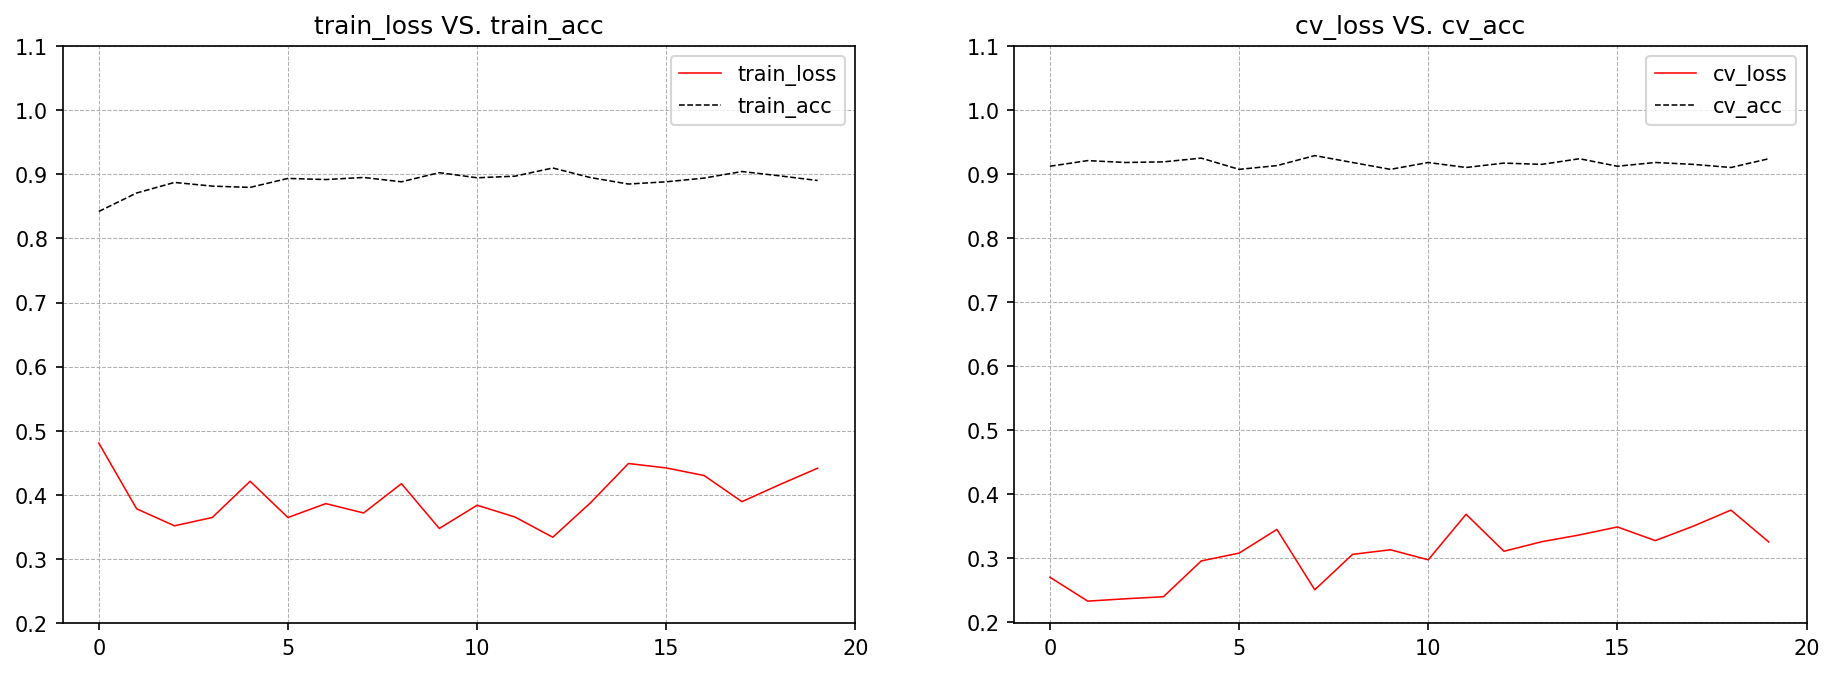

In [27]:
import matplotlib.pyplot as plt
metrics = [('train_loss', 'train_acc'),
           ('cv_loss', 'cv_acc')]

fig = plt.figure(figsize=[15, 5], dpi=150)
for index, (loss, acc) in enumerate(metrics):
    fig.add_subplot(1, 2, index + 1)
    plt.plot(
        np.arange(len(model.history[loss])),
        model.history[loss],
        label=loss,
        color='red',
        linewidth = 0.75,
    )
    plt.plot(
        np.arange(len(model.history[loss])),
        model.history[acc],
        label = acc,
        color='black',
        linewidth = 0.75,
        linestyle='--'
    )
    plt.legend()
    plt.title(f'{loss } VS. {acc}')
    plt.xticks(np.linspace(0, len(model.history[loss]), 5))
    plt.yticks(np.arange(0.2, 1.2, 0.1))
    plt.grid(linestyle='--', linewidth=0.5)
plt.savefig(MODEL_FOLDER / 'loss_acc_history.jpg')

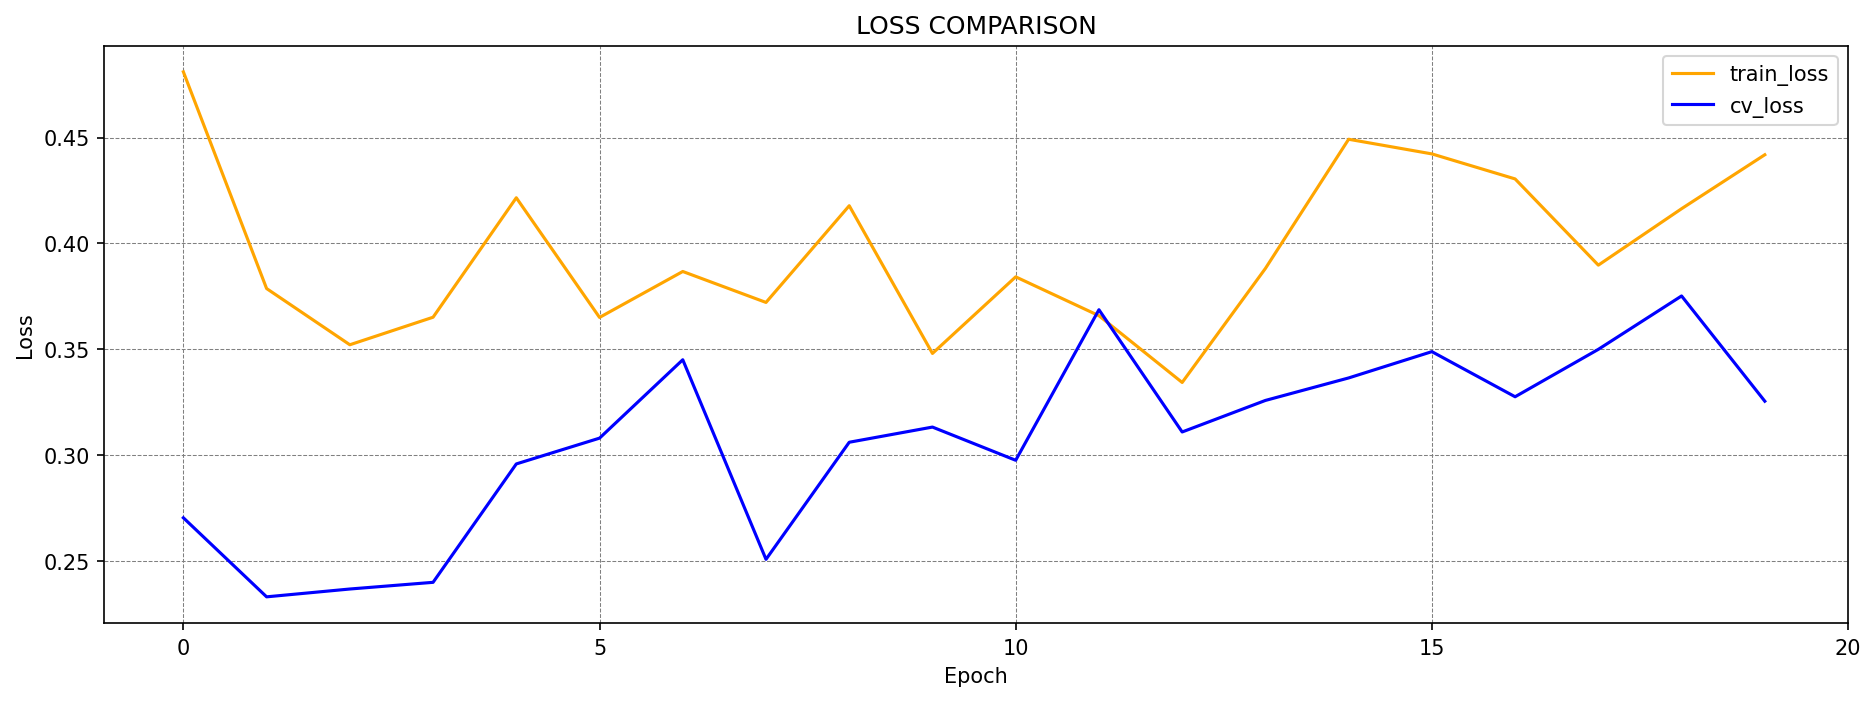

In [28]:
fig = plt.figure(figsize=[15, 5], dpi=150)
plt.plot(np.arange(len(model.history[loss])), model.history['train_loss'], color='orange', label='train_loss')
plt.plot(np.arange(len(model.history[loss])), model.history['cv_loss'], color='blue', label='cv_loss')
plt.title('LOSS COMPARISON')
plt.xticks(np.linspace(0, len(model.history[loss]), 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(linewidth='.5', linestyle='--', color='gray')
plt.savefig(MODEL_FOLDER / 'loss_comparison.jpg')

### Let's measure the weight of the model

In [ ]:
MODEL_FILE = pathlib.Path('/Users/thomaspierantozzi/PycharmProjects/PyTorch_Train/06_PyTorch_TransferLearning/saved_models/EffNet_b2_Augmented/model_checkpoint_epoch_20.pt')
model_size = MODEL_FILE.stat().st_size // 2 ** 20
print (f'The model size is {model_size} MB')